<a href="https://colab.research.google.com/github/ThibaudARoy/LandSatAGB/blob/master/model1_smallNorb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle, gzip
from load_smallnorb import load_smallnorb

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
load_from_file = True


In [4]:
(train_images, train_labels),(test_images,test_labels) = load_smallnorb()

In [5]:
category_labels = ['animal', 'human', 'airplane', 'truck', 'car']

In [6]:
n_categories = len(category_labels)

In [7]:
if not os.path.isdir("saved"):
   os.mkdir('saved')

In [8]:
# Specify the names of the save files
save_name = os.path.join('saved', 'smallNORB')
net_save_name = save_name + '_cnn_net.h5'
history_save_name = save_name + '_cnn_net.hist'

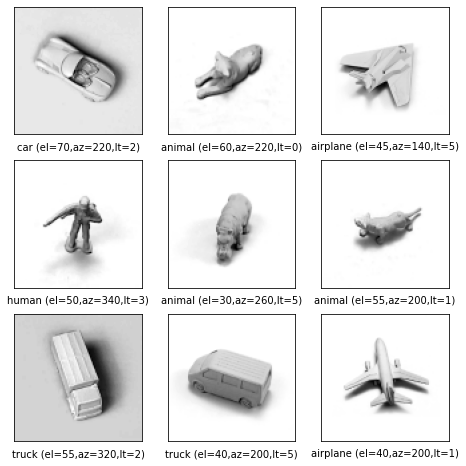

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)


for i, ax in enumerate(axes.flat):
    # Just show the left image
    image = train_images[i,:,:,0]
      # Fetch category
    category_str = category_labels[train_labels[i,2]]
      # Get the azimuth
    azimuth = train_labels[i,1]*20
      # Get the elevation
    elevation = train_labels[i,3]*5+30
      # Get the lighting
    lighting = train_labels[i,4]

      # Show image
    ax.imshow(image, cmap='gray')
    ax.text(0.5, -0.12, f'{category_str} (el={elevation},az={azimuth},lt={lighting})', ha='center',
    transform=ax.transAxes, color='black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [10]:
train_images.shape

(24300, 96, 96, 2)

In [11]:
# Define batch size
batch_size = 128

# Compute the mean and standard deviation of the training data
num_batches = int(np.ceil(train_images.shape[0] / batch_size))
mean = np.zeros_like(train_images[0], dtype=np.float64)
std = np.zeros_like(train_images[0], dtype=np.float64)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_images = train_images[start_idx:end_idx]
    batch_mean = np.mean(batch_images, axis=0)
    batch_std = np.std(batch_images, axis=0)
    mean += batch_mean
    std += batch_std

mean /= num_batches
std /= num_batches

# Normalize the training data
train_images_norm = np.zeros_like(train_images, dtype=np.float64)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_images = train_images[start_idx:end_idx]
    train_images_norm[start_idx:end_idx] = (batch_images - mean) / std

# Normalize the testing data
num_batches = int(np.ceil(test_images.shape[0] / batch_size))
test_images_norm = np.zeros_like(test_images, dtype=np.float64)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_images = test_images[start_idx:end_idx]
    test_images_norm[start_idx:end_idx] = (batch_images - mean) / std

In [ ]:
# Assume train_data_norm and test_data_norm contain the normalized data
print("Train data mean: ", np.mean(train_images_norm))
print("Train data std: ", np.std(train_images_norm))
print("Test data mean: ", np.mean(test_images_norm))
print("Test data std: ", np.std(test_images_norm))

Train data mean:  -1.2846651837459428e-05


In [ ]:
train_images_norm[0].shape

In [ ]:
input_shape = train_images_norm[0]

In [ ]:
if load_from_file and os.path.isfile(net_save_name):
   # ***************************************************
   # * Loading previously trained neural network model *
   # ***************************************************

   # Load the model from file
   print("Loading neural network from %s..." % net_save_name)
   net = tf.keras.models.load_model(net_save_name)

   # Load the training history - since it should have been created right after
   # saving the model
   if os.path.isfile(history_save_name):
      with gzip.open(history_save_name) as f:
         history = pickle.load(f)
   else:
      history = []
else:
   # ************************************************
   # * Creating and training a neural network model *
   # ************************************************

   # Define the input layer
    inputs = Input(shape=(96,96,2))

    # convolutional layers
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(inputs)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=128,kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=256,kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # flatten layer
    x = Flatten()(x)

    # classification branch
    x_class = Dense(units=128, activation='relu')(x)
    x_class = Dense(units=512, activation='relu')(x_class)
    class_output = Dense(units=n_categories, activation='softmax', name='class_output')(x_class)

    # regression branch
    x_reg = Dense(128, activation='relu')(x)
    x_reg = Dense(64, activation='relu')(x_reg)
    reg_output = Dense(1, activation='linear', name='reg_output')(x_reg)

    # define model
    net = Model(inputs=inputs, outputs=[class_output, reg_output])

    # compile model
    net.compile(optimizer='adam',
              loss={'class_output': 'sparse_categorical_crossentropy', 'reg_output': 'mse'},
              metrics={'class_output': 'accuracy', 'reg_output': 'mae'})


    # train model
    train_info = net.fit(train_images_norm, {'class_output': train_labels[:,2], 'reg_output': train_labels[:,3]}, epochs=2, batch_size=32, validation_split=0.2, shuffle=True)


   # Save the model to file
    print("Saving neural network to %s..." % net_save_name)
    net.save(net_save_name)

   # Save training history to file 
    history = train_info.history
    with gzip.open(history_save_name, 'w') as f:
      pickle.dump(history, f)


In [ ]:
print(history)

In [ ]:
# plot training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# plot classification accuracy
plt.plot(history['class_output_accuracy'])
plt.plot(history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# plot regression accuracy
plt.plot(history['reg_output_mae'])
plt.plot(history['val_reg_output_mae'])
plt.title('Regression Accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# evaluating model within tensorflow

test_loss, test_class_loss, test_reg_loss, test_class_acc, test_reg_mae = net.evaluate(test_images_norm, {'class_output': test_labels[:,2], 'reg_output': test_labels[:,3]})



In [ ]:

# Save the results to a file
with open('model_evaluation.pkl', 'wb') as f:
    pickle.dump([test_loss, test_class_loss, test_reg_loss, test_class_acc, test_reg_mae], f)

# Load the results from the file
with open('model_evaluation.pkl', 'rb') as f:
    results = pickle.load(f)


In [ ]:
# Access the individual results
test_loss = results[0]
test_class_loss = results[1]
test_reg_loss = results[2]
test_class_acc = results[3]
test_reg_mae = results[4]

In [ ]:
# print the results
print("Test loss:", test_loss)
print("Test classification loss:", test_class_loss)
print("Test regression loss:", test_reg_loss)
print("Test classification accuracy:", test_class_acc)
print("Test regression MAE:", test_reg_mae)

In [ ]:
import seaborn as sns

In [ ]:
# Create a bar plot of the classification accuracy
sns.barplot(x=['Test classification accuracy'], y=[test_class_acc])
plt.title('Test classification accuracy')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Create a bar plot of the regression MAE
sns.barplot(x=['Test regression MAE'], y=[test_reg_mae])
plt.title('Test regression MAE')
plt.show()

In [ ]:
# find the range of values in train_labels[:,3]
train_labels_elevation_range = (np.amin(train_labels[:,3]), np.amax(train_labels[:,3]))
print("Train labels[:,3] range:", train_labels_elevation_range)

In [ ]:
# Create a heatmap of the confusion matrix
from sklearn.metrics import confusion_matrix

In [ ]:
# Make predictions on the test set
test_pred = net.predict(test_images_norm)

# Convert predictions to integer values
test_class_pred = np.argmax(test_pred[:,0], axis=-1)
test_reg_pred = np.round(test_pred[:,1]*48)

# Build confusion matrix
conf_matrix = confusion_matrix(test_labels[:,2], test_class_pred)

# Visualize confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=[str(i) for i in range(5)], yticklabels=[str(i) for i in range(5)])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for Classification')
plt.show()
